# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In this data analysis, since we are going to investigate the impact of each offer type on the customers. My strategy for solving this problem has four steps. First, I will combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will assess the accuracy to juedge my model. This provides me a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. In other words, we will use accuracy as the main metric to understand the pro and cons of our machine learning model, which is much more intuitive and direct for the decision-makers compared to other metrics like F-1 score.

In [3]:
# Import all the necessary library
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb 
import warnings
import statsmodels.api as sm
from datetime import datetime
from time import time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate
from sklearn import metrics
import xgboost
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Analysis (Data Exploraion & Data Visualization)

## 1.1. Data Exploration

### 1.1.1 Data Review for "portfolio" 

In [3]:
# Quick check the portfolio information 
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


### 1.1.2 Data Review for "profile" 

In [4]:
# Quick check the profile information
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
#check the NaN information
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

It can be seen that for the number of NaN in gender column is same as the number of NaN in income column. one assumption is that for the people who did not provide the gender information, they neither provide the income information, let us have a look if the assumption is correct or not!

In [6]:
#check the NaN information to see the match informtion of NaN
totalNaN = profile.isnull().sum().sum()
totalNaN_withgenderinfor =profile.query('gender == "F" or gender == "M"').isnull().sum().sum()
print('The total number of NaN is: ',totalNaN)
print('The total number of NaN （for the users whose gender are known）: ',totalNaN_withgenderinfor)

The total number of NaN is:  4350
The total number of NaN （for the users whose gender are known）:  0


In [7]:
#check the information of those customers whose age is 118
profile[profile['age']==118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


It is clear that some customer did not provide the information of their gender and income, the system automatically set the age of the customer to 118

### 1.1.3 Data Review for "transcript" 

In [8]:
# Quick check the transcript information 
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
# NaN information checking
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

## 1.2 Data Visualization 

### 1.2.1 Data Visualization of "portfolio" 

<AxesSubplot:xlabel='offer_type', ylabel='count'>

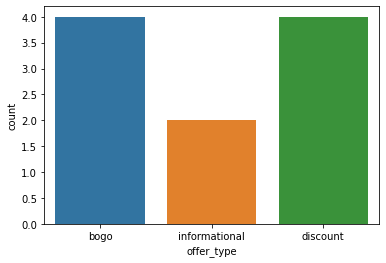

In [34]:
#offer types and the corresponding frequencies
sb.countplot(data = portfolio, x = 'offer_type')

Text(0, 0.5, 'Duration (days)')

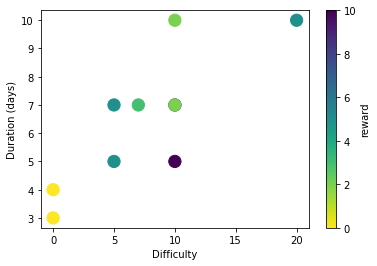

In [10]:
# The reward distribution along the difficulty and duration
plt.scatter (data = portfolio, x = 'difficulty', y = 'duration', c = 'reward', 
             s = 150,cmap = 'viridis_r')
plt.colorbar(label = 'reward')
plt.xlabel('Difficulty')
plt.ylabel('Duration (days)')

Text(0, 0.5, 'Average Reward ($)')

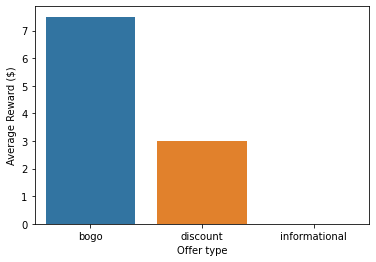

In [11]:
# The relation bewteen offer_type and reward level
offer_type = portfolio.groupby('offer_type').mean()['reward'].index.values
average_reward = portfolio.groupby('offer_type').mean()['reward']
sb.barplot(offer_type, average_reward)
plt.xlabel('Offer type')
plt.ylabel('Average Reward ($)')

Bogo usually provides the largest average rewards, and informational offer usually means no rewarding

### 1.2.2 Data Visualization of "profile"

<AxesSubplot:xlabel='gender', ylabel='count'>

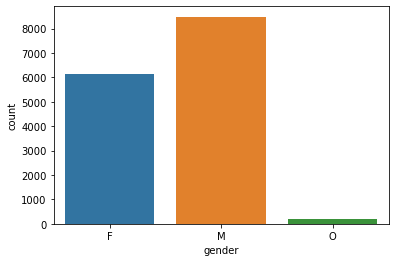

In [12]:
#check the gender distribution of Starbucks customers 
sb.countplot(data = profile, x = 'gender')

(0.0, 110.0)

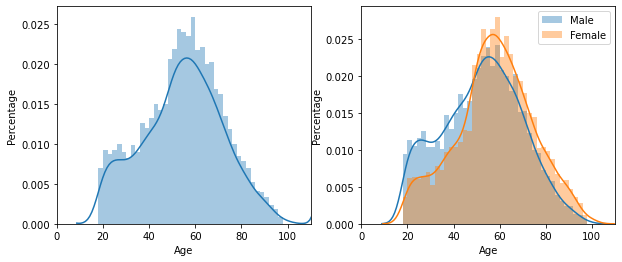

In [13]:
#check the age distribution of Starbucks customers 
plt.figure(figsize= [10,4])

plt.subplot(1,2,1)
bins = np.arange(profile['age'].min(), 100,2)
sb.distplot(profile['age'], bins = bins);
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xlim([0,110])

plt.subplot(1,2,2)
bins = np.arange(profile['age'].min(), 100,2)
sb.distplot(profile[profile['gender']=='M']['age'], bins = bins);
sb.distplot(profile[profile['gender']=='F']['age'], bins = bins);
plt.legend(['Male', 'Female'])
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xlim([0,110])

Text(0, 0.5, 'Percentage')

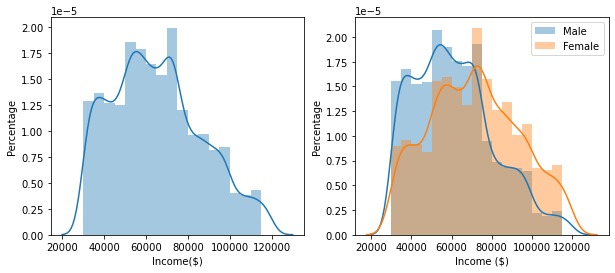

In [14]:
#check the income distribution of Starbucks customers 
plt.figure(figsize= [10,4])

plt.subplot(1,2,1)
bins = np.arange(profile['income'].min(), profile['income'].max(),5000)
sb.distplot(profile['income'], bins = bins);
plt.xlabel('Income($)')
plt.ylabel('Percentage')

plt.subplot(1,2,2)
bins = np.arange(profile['income'].min(), profile['income'].max(),5000)
sb.distplot(profile[profile['gender']=='M']['income'], bins = bins);
sb.distplot(profile[profile['gender']=='F']['income'], bins = bins);
plt.legend(['Male', 'Female'])
plt.xlabel('Income ($)')
plt.ylabel('Percentage')

Text(0, 0.5, 'Age')

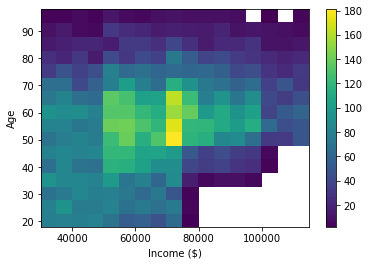

In [15]:
#heat map of "profile" (according to income and age) 
biny = np.arange(18,100,5)
binx = np.arange(30000,120000,5000)
plt.hist2d(data = profile.dropna(), x='income', y='age', bins = [binx, biny], cmin = 2);
plt.colorbar()
plt.xlabel('Income ($)')
plt.ylabel('Age')

It can be noticed that the customers with ~$75000 income per year and 50-60 age like Starbucks a lot.

Text(0, 0.5, 'Number of Customers')

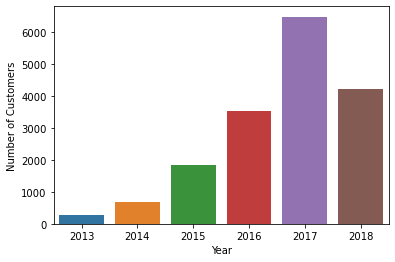

In [16]:
# check the number of customers from each years
sb.countplot(profile['became_member_on']//10000)
plt.xlabel('Year')
plt.ylabel('Number of Customers')

### 1.2.3 Data Visualization of "transcript"

<AxesSubplot:xlabel='event', ylabel='count'>

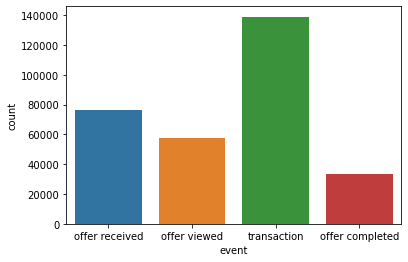

In [17]:
sb.countplot(data = transcript, x = 'event')

# 2. Methodology (Data Prepocessing & Implementation) 

## 2.1 Data Cleaning 

### 2.1.1 Data Cleaning for "portfolio" 

In [18]:
def clean_portfolio(portfolio):
    '''
    Cleaning the portfolio dataset
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio_new - the cleaned portfolio dataframe
    
    '''
    
    #build the dummy array for the information of "channels" and "offertype"
    portfolio_new = portfolio.copy()
    portfolio_new['email'] =  portfolio_new['channels'].apply(lambda val: 1 if 'email' in val else 0)
    portfolio_new['mobile'] = portfolio_new['channels'].apply(lambda val: 1 if 'mobile' in val else 0)
    portfolio_new['web'] = portfolio_new['channels'].apply(lambda val: 1 if 'web' in val else 0)
    portfolio_new['social'] = portfolio_new['channels'].apply(lambda val: 1 if 'social' in val else 0)
    #portfolio_new = pd.concat([portfolio_new,pd.get_dummies(portfolio_new['offer_type'])], axis = 1)
    
    #adjust the columns sequence
    portfolio_new.drop(['channels'], axis = 1)
    portfolio_new = portfolio_new[['id','reward','difficulty','duration',\
                                   'email','mobile','web','social','offer_type']]
    
    #rename the "id" to "offer_id"
    portfolio_new.rename(columns = {'id':'offer_id'}, inplace = True)
    
    return portfolio_new

portfolio_new = clean_portfolio(portfolio)
portfolio_new.head()

,offer_id,reward,difficulty,duration,email,mobile,web,social,offer_type
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,0,1,bogo
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,bogo
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,1,0,informational
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,1,0,bogo
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,1,0,discount


### 2.1.2  Data Cleaning for "profile"

In [19]:
datetime.today().date()

datetime.date(2020, 9, 7)

In [20]:
def clean_profile(profile):
    '''
    Cleaning the profile dataset
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile_new - the cleaned profile dataframe
    
    '''
    profile_new = profile.copy()
    
    #modity the became_member_on to date format
    
    #profile_new['became_member_on'] = \
    #pd.to_datetime(profile_new['became_member_on'], format='%Y%m%d').dt.date
    #profile_new['became_member_on'] = pd.to_datetime(profile_new['became_member_on'])
    #profile_new['member_year'] = profile_new['became_member_on'].dt.year
    profile_new['days']= datetime.today().date() - \
    pd.to_datetime(profile_new['became_member_on'], format='%Y%m%d').dt.date
    profile_new['days'] = profile_new['days'].dt.days
    #fill all of the NaN information
    profile_new['gender'].fillna('O', inplace=True)
    profile_new['income'].fillna((profile['income'].mean()), inplace=True)
        
    #build the dummy array for the gender information
    profile_new = pd.concat([profile_new,pd.get_dummies(profile_new['gender'])], axis = 1)
    
    #drop the unnecessary columns 
    profile_new.drop(['became_member_on'], axis = 1, inplace = True)
    
    #adjust the columns sequence
    profile_new = profile_new[['id','age','income','days','gender']]
    profile_new.rename(columns = {'id':'person'}, inplace = True)
    
    return profile_new
profile_new =  clean_profile(profile)
profile_new.head()

,person,age,income,days,gender
0,68be06ca386d4c31939f3a4f0e3dd783,118,65404.991568,1303,O
1,0610b486422d4921ae7d2bf64640c50b,55,112000.000000,1150,F
2,38fe809add3b4fcf9315a9694bb96ff5,118,65404.991568,788,O
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.000000,1217,F
4,a03223e636434f42ac4c3df47e8bac43,118,65404.991568,1130,O


### 2.1.3 Data Cleaning for "transcript" 

In [21]:
def clean_transcript(transcript):
    '''
    Cleaning the transcript dataset
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript_new - the cleaned transcript dataframe
    
    '''
    
    transcript_new = transcript.copy()
    
    # extract all the 'transaction' information 
    df1 = transcript_new[transcript_new['event'] == 'transaction']
    df1['amount'] = df1.value.apply(lambda x:list(x.values())[0])
    
    # extract all of the 'offer received' information
    df2 = transcript[transcript['event'] == 'offer received']
    df2['offer_id'] = df2.value.apply(lambda x:list(x.values())[0])
    
    # extract all of the 'offer viewed' information
    df3 = transcript[transcript['event'] == 'offer viewed']
    df3['offer_id'] = df3.value.apply(lambda x:list(x.values())[0])
    
    # extract all of the 'offer completed' information
    df4 = transcript[transcript['event'] == 'offer completed']
    df4['offer_id'] = df4.value.apply(lambda x:list(x.values())[0])
    df4['reward'] = df4.value.apply(lambda x:list(x.values())[1])
    
    # combine all the event information together
    transcript_new = pd.concat([df1,df2,df3,df4])
    transcript_new = transcript_new[['event' , 'person' , 'offer_id' ,\
                                     'time', 'amount' , 'reward' , 'value']]
    
    #generating the dummy array from the event 
    transcript_new = pd.get_dummies(transcript_new, columns=['event'] , prefix='' ,prefix_sep='')
    
    #drop the unecessary data as well as the duplicated values
    transcript_new.drop(columns='value' , inplace=True)
    transcript_new.drop_duplicates(inplace=True)
    
    return transcript_new

transcript_new =  clean_transcript(transcript)
transcript_new.head()

<ipython-input-21-8918fdb81fb0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['amount'] = df1.value.apply(lambda x:list(x.values())[0])
<ipython-input-21-8918fdb81fb0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['offer_id'] = df2.value.apply(lambda x:list(x.values())[0])
<ipython-input-21-8918fdb81fb0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN,0,0,0,1


## 2.2 Data Processing 

Data Processing is for the model setup in the next step. In this project, we concern about the question which demographic groups respond best to which offer type? What is the best offer strategy for Starbucks. Therefore, we have to generate some chart, which includes the information customer response to each type of reward offer. 

Firstly, we would combine all the three tables together

In [22]:
#merge the transcript_new and profile_new table 
temp_1 = pd.merge(transcript_new, profile_new, on = 'person', how = 'inner')
temp_1['reward'].fillna(0, inplace = True)
temp_1['amount'].fillna(0, inplace = True)
temp_1.head(5)

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,income,days,gender
0,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,0.0,0,0,0,1,20,30000.0,1519,F
1,02c083884c7d45b39cc68e1314fec56c,NaN,6,1.44,0.0,0,0,0,1,20,30000.0,1519,F
2,02c083884c7d45b39cc68e1314fec56c,NaN,12,4.56,0.0,0,0,0,1,20,30000.0,1519,F
3,02c083884c7d45b39cc68e1314fec56c,NaN,84,1.53,0.0,0,0,0,1,20,30000.0,1519,F
4,02c083884c7d45b39cc68e1314fec56c,NaN,90,0.50,0.0,0,0,0,1,20,30000.0,1519,F


In [23]:
# merge the temp_1 file with the portfolio file
temp_2 = pd.merge(temp_1, portfolio_new, on = 'offer_id', how = 'left')
temp_2.columns.values

array(['person', 'offer_id', 'time', 'amount', 'reward_x',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'age', 'income', 'days', 'gender', 'reward_y', 'difficulty',
       'duration', 'email', 'mobile', 'web', 'social', 'offer_type'],
      dtype=object)

Here，we noticed that there are lots of columns in the chart of temp_2, actually, we do not need consider so many things, so I will only consider the most important parts as shown below

In [24]:
temp_2 = temp_2[['person','time', 'offer completed', 'offer received', \
                 'offer viewed', 'transaction','age', 'income', 'days', 'gender',\
                 'offer_type','duration','offer_id']]
temp_2.sort_values(['person','time'],inplace = True)
temp_2.head(5)

,person,time,offer completed,offer received,offer viewed,transaction,age,income,days,gender,offer_type,duration,offer_id
258871,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,33,72000.0,1235,M,informational,3.0,5a8bc65990b245e5a138643cd4eb9837
258876,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,33,72000.0,1235,M,informational,3.0,5a8bc65990b245e5a138643cd4eb9837
258863,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,33,72000.0,1235,M,NaN,NaN,NaN
258872,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,33,72000.0,1235,M,informational,4.0,3f207df678b143eea3cee63160fa8bed
258877,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,33,72000.0,1235,M,informational,4.0,3f207df678b143eea3cee63160fa8bed


We know that bogo and discount are easier to analyze, the reason is if the customers are affected by the offers of bogo or discount, they purchase starbucks, then it will show "offer completed", therefore, we can make our modeling based on the fact whether offers are completed or not for bogos and discount. However, informational offer won't show if the purchase completed due to offer affecting. Therefore, we may need to clarify the category of each purchase.

Here, we checked all of the informational offer (viewed by the customer) and check if the purchase can be finished before to the expiration of the informational offer. If the purchase can be finished before the expiration, we would define that the informational offer is completed.

In [25]:
temp_array = np.array(temp_2)
temp_array.shape[0]

306137

In [26]:
for i in range(len(temp_array)):
    # Check if the informational offer has been viewed or not
    if temp_array[i,10]=='informational' and temp_array[i,4]==1:
        # Check the person and offer id
        person = temp_array[i,0]
        offer_id = temp_array[i,12]
        # find out the start time of this informational offer
        start_time = temp_2[(temp_2['person'] == person) & (temp_2['offer_id'] == offer_id)]['time'].values[0]
        j = i + 1
        while(temp_array[j,0]==temp_array[i,0] and \
              (temp_array[j,1]-start_time) <= temp_array[i,11]*24):
            if temp_array[j,5]==1:
                temp_2.iloc[i,2] = 1
            j += 1   

We would like to save the temp_2 file to another csv file so that we can do more operation on this file later

In [4]:
temp_2.to_csv('temporary.csv')

NameError: name 'temp_2' is not defined

In [5]:
temp_2 = pd.read_csv('temporary.csv')
temp_3 = temp_2.groupby(['person','offer_type']).agg(
    {
        'offer completed': sum,
        'offer received': sum,
        'offer viewed': sum,
        'age': 'last',
        'income':'last',
        'days':'last',
        'gender':'last',
    }
).reset_index()

In [6]:
temp_3.head()

,person,offer_type,offer completed,offer received,offer viewed,age,income,days,gender
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,33,72000.000000,1235,M
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,33,72000.000000,1235,M
2,0009655768c64bdeb2e877511632db8f,informational,2,2,2,33,72000.000000,1235,M
3,00116118485d4dfda04fdbaba9a87b5c,bogo,0,2,2,118,65404.991568,866,O
4,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,1,40,57000.000000,972,O


In [7]:
temp_3 = pd.concat([temp_3,pd.get_dummies(temp_3['gender'])], axis = 1)
temp_3['percent'] = temp_3['offer completed']/temp_3['offer received']
temp_3.drop(['gender'], axis = 1, inplace = True)
temp_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           40484 non-null  object 
 1   offer_type       40484 non-null  object 
 2   offer completed  40484 non-null  int64  
 3   offer received   40484 non-null  int64  
 4   offer viewed     40484 non-null  int64  
 5   age              40484 non-null  int64  
 6   income           40484 non-null  float64
 7   days             40484 non-null  int64  
 8   F                40484 non-null  uint8  
 9   M                40484 non-null  uint8  
 10  O                40484 non-null  uint8  
 11  percent          40484 non-null  float64
dtypes: float64(2), int64(5), object(2), uint8(3)
memory usage: 2.9+ MB


In [8]:
temp_3['useful'] = temp_3['percent'].apply(lambda val: 1 if val > 0.7 else 0) 

In [9]:
temp_3.head()

,person,offer_type,offer completed,offer received,offer viewed,age,income,days,F,M,O,percent,useful
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,33,72000.000000,1235,0,1,0,1.0,1
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,33,72000.000000,1235,0,1,0,1.0,1
2,0009655768c64bdeb2e877511632db8f,informational,2,2,2,33,72000.000000,1235,0,1,0,1.0,1
3,00116118485d4dfda04fdbaba9a87b5c,bogo,0,2,2,118,65404.991568,866,0,0,1,0.0,0
4,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,1,40,57000.000000,972,0,0,1,1.0,1


## 2.3 Model Implementation 

In this project, we concern about the question which demographic groups respond best to which offer type? What is the best offer strategy for Starbucks. And we have to generate the above chart, which includes the information customer response to each type of reward offer. We will use Accuracy as the main metric, which is much easier and intuitive for the decision maker to make the final decision. Compared to F1 score, precision, reall or specificity, accuracy gives a relatively more direct perspective 

In [10]:
# split the chart into three part, 'bogo','discount','informational'
temp_bogo = temp_3[temp_3['offer_type']=='bogo']
temp_discount = temp_3[temp_3['offer_type']=='discount']
temp_informational = temp_3[temp_3['offer_type']=='informational']
X_bogo = temp_bogo.iloc[:,5:11]
y_bogo = temp_bogo.iloc[:,12]
X_discount = temp_discount.iloc[:,5:11]
y_discount = temp_discount.iloc[:,12]
X_informational = temp_informational.iloc[:,5:11]
y_informational = temp_informational.iloc[:,12]

In [11]:
# splilt the data set into training and testing 
X_train_bogo, X_test_bogo, y_train_bogo, y_test_bogo = \
train_test_split(X_bogo, y_bogo, test_size =0.3, random_state = 16)

X_train_discount, X_test_discount, y_train_discount, y_test_discount = \
train_test_split(X_discount, y_discount, test_size =0.3, random_state = 16)

X_train_informational, X_test_informational, y_train_informational, y_test_informational = \
train_test_split(X_informational, y_informational, test_size =0.3, random_state = 16)


### 2.3.1 KNN method 

The proximity algorithm, or K-Nearest Neighbor (K-NearestNeighbor) classification algorithm is one of the simplest methods in data mining classification technology. The so-called K nearest neighbors means K nearest neighbors, which means that each sample can be represented by its K nearest neighbors. The nearest neighbor algorithm is a method to classify each record in the data set. The independent variables can include many, such as age, gender, income, etc. We can classify the neighbors according to the independent variables to determine whether customers will be affected by Starbucks rewards

In [12]:
#KNN for bogo
KNN_bogo = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,\
           weights='uniform')
KNN_bogo.fit(X_train_bogo, y_train_bogo)
y_pred_bogo = KNN_bogo.predict(X_test_bogo)

#KNN for discount
KNN_discount = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,\
           weights='uniform')
KNN_discount.fit(X_train_discount, y_train_discount)
y_pred_discount = KNN_discount.predict(X_test_discount)
                                    
#KNN for informational offer
KNN_informational = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,\
           weights='uniform')
KNN_informational.fit(X_train_informational, y_train_informational)
y_pred_informational = KNN_informational.predict(X_test_informational)

In [13]:
print('Bogo offer prediction accuracy: ',accuracy_score(y_test_bogo, y_pred_bogo))
print('Discount offer prediction accuracy: ',accuracy_score(y_test_discount, y_pred_discount))
print('Informational offer prediction accuracy: ',accuracy_score(y_test_informational, y_pred_informational))

Bogo offer prediction accuracy:  0.6823032458870609
Discount offer prediction accuracy:  0.6619090098126673
Informational offer prediction accuracy:  0.7026856240126382


### 2.3.2 Logistic Regression method 

Logistic regression is a generalized linear regression analysis model, often used in data mining, automatic disease diagnosis, economic forecasting and other fields. For example, explore the risk factors that cause diseases, and predict the probability of disease occurrence based on the risk factors. Taking Starbucks discount analysis as an example, two groups of people are selected, one group is the group affected by the coupon, the other group is the group not affected by the coupon, and the two groups must have different physical signs and lifestyles. Therefore, the dependent variable is whether it will be affected by the coupon, the value is "yes" or "no", and the independent variables can include many, such as age, gender, income, etc.

In [14]:
#Logistic regression for bogo
log_bogo = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
log_bogo.fit(X_train_bogo, y_train_bogo)
y_pred_bogo = log_bogo.predict(X_test_bogo)

#Logistic regression for discount
log_discount = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
log_discount.fit(X_train_discount, y_train_discount)
y_pred_discount = log_discount.predict(X_test_discount)
                                    
#Logistic regression for informational offer
log_informational = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
log_informational.fit(X_train_informational, y_train_informational)
y_pred_informational = log_informational.predict(X_test_informational)

In [15]:
print('Bogo offer prediction accuracy: ',accuracy_score(y_test_bogo, y_pred_bogo))
print('Discount offer prediction accuracy: ',accuracy_score(y_test_discount, y_pred_discount))
print('Informational offer prediction accuracy: ',accuracy_score(y_test_informational, y_pred_informational))

Bogo offer prediction accuracy:  0.5927078701645175
Discount offer prediction accuracy:  0.6853256021409456
Informational offer prediction accuracy:  0.7424960505529226


### 2.3.3 Random Forest Classifier 

Random forest is a classifier that contains multiple decision trees, and its output category is determined by the mode of the output category of individual trees. Can be used in this project to analyze whether customers will be affected by Starbucks offers

In [16]:
# Random Forest Classifier_Bogo 
RF_bogo = RandomForestClassifier(max_depth=5,min_samples_leaf=8, min_samples_split=20,\
                              min_weight_fraction_leaf=0.0, random_state=16)
RF_bogo.fit(X_train_bogo, y_train_bogo)
y_pred_bogo = RF_bogo.predict(X_test_bogo)

# Random Forest Classifier_Discount 
RF_discount = RandomForestClassifier(max_depth=5,min_samples_leaf=8, min_samples_split=20,\
                              min_weight_fraction_leaf=0.0, random_state=16)
RF_discount.fit(X_train_discount, y_train_discount)
y_pred_discount = RF_discount.predict(X_test_discount)

# Random Forest Classifier_Informational
RF_informational = RandomForestClassifier(max_depth=5,min_samples_leaf=8, min_samples_split=20,\
                              min_weight_fraction_leaf=0.0, random_state=16)
RF_informational.fit(X_train_informational, y_train_informational)
y_pred_informational = RF_informational.predict(X_test_informational)

In [17]:
print('Bogo offer prediction accuracy: ',accuracy_score(y_test_bogo, y_pred_bogo))
print('Discount offer prediction accuracy: ',accuracy_score(y_test_discount, y_pred_discount))
print('Informational offer prediction accuracy: ',accuracy_score(y_test_informational, y_pred_informational))

Bogo offer prediction accuracy:  0.7289906625166741
Discount offer prediction accuracy:  0.7143175735950045
Informational offer prediction accuracy:  0.7424960505529226


### 2.3.4 Decision Tree Classifier 

Decision Tree is based on the known probability of occurrence of various situations, by constructing a decision tree to obtain the probability that the expected value of the net present value is greater than or equal to zero, evaluate project risk, and determine its feasibility. A graphical method of intuitive use of probability analysis, which can be used in this project to understand if a specific customer would be affected by the reward offers.

In [18]:
#Decision Tree Classifier_Bogo 
tree_bogo = DecisionTreeClassifier(max_depth=5,min_samples_leaf=8, min_samples_split=20,\
                              min_weight_fraction_leaf=0.0, random_state=16)
tree_bogo.fit(X_train_bogo, y_train_bogo)
y_pred_bogo = tree_bogo.predict(X_test_bogo)

#Decision Tree Classifier_Discount 
tree_discount = DecisionTreeClassifier(max_depth=5,min_samples_leaf=8, min_samples_split=20,\
                              min_weight_fraction_leaf=0.0, random_state=16)
tree_discount.fit(X_train_discount, y_train_discount)
y_pred_discount = tree_discount.predict(X_test_discount)

#Decision Tree Classifier_Informational
tree_informational = DecisionTreeClassifier(max_depth=5,min_samples_leaf=8, min_samples_split=20,\
                              min_weight_fraction_leaf=0.0, random_state=16)
tree_informational.fit(X_train_informational, y_train_informational)
y_pred_informational = tree_informational.predict(X_test_informational)

In [19]:
print('Bogo offer prediction accuracy: ',accuracy_score(y_test_bogo, y_pred_bogo))
print('Discount offer prediction accuracy: ',accuracy_score(y_test_discount, y_pred_discount))
print('Informational offer prediction accuracy: ',accuracy_score(y_test_informational, y_pred_informational))

Bogo offer prediction accuracy:  0.7269897732325478
Discount offer prediction accuracy:  0.7163247100802854
Informational offer prediction accuracy:  0.7399684044233807


Looks like Decision Tree Classifier has a higher prediction rate compared to the other methods

# 3. Results 

## 3.1 Model Evaluation and Validation 

In [38]:
print('Bogo offer prediction accuracy: ',accuracy_score(y_test_bogo, y_pred_bogo))
print('Discount offer prediction accuracy: ',accuracy_score(y_test_discount, y_pred_discount))
print('Informational offer prediction accuracy: ',accuracy_score(y_test_informational, y_pred_informational))

Bogo offer prediction accuracy:  0.7269897732325478
Discount offer prediction accuracy:  0.7163247100802854
Informational offer prediction accuracy:  0.7399684044233807


In [39]:
confusion_matrix(y_test_bogo, y_pred_bogo)

array([[1980,  685],
       [ 543, 1290]], dtype=int64)

The confusion matrix shown above is the bogo offer estimation, the columns means the prediction and the rows mean the ground truth (the first column and first row is 0, which means the the user won't be affected by the bogo offer, the second column and second row is 0, which means the the user will be affected by the bogo offer). As can be seen, take the Decision tree classifier as an exapmle, the prediction accuracy is as high as 73%. By looking the the confusion matrix, we know that the people who will not be affected by the bogo offer is 1980 + 685 = 2665 and the number of customers who will be affected by the bogo offer is 543 + 1290 = 1833. the accuracy of our prediction is (1980 + 1290)/(543 + 685 + 1980 + 1290) = ~0.73.

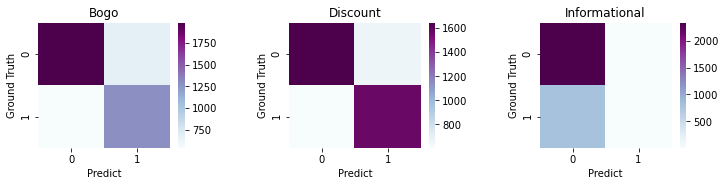

In [20]:
# Plot the confusion matrix for each type of offers
plt.figure(figsize= [10,2.5])

plt.subplot(1,3,1)
sb.heatmap(confusion_matrix(y_test_bogo, y_pred_bogo),cmap="BuPu")
plt.title('Bogo')
plt.xlabel('Predict')
plt.ylabel('Ground Truth')

plt.subplot(1,3,2)
sb.heatmap(confusion_matrix(y_test_discount, y_pred_discount),cmap="BuPu")
plt.title('Discount')
plt.xlabel('Predict')
plt.ylabel('Ground Truth')

plt.subplot(1,3,3)
sb.heatmap(confusion_matrix(y_test_informational, y_pred_informational),cmap="BuPu")
plt.title('Informational')
plt.xlabel('Predict')
plt.ylabel('Ground Truth')

plt.tight_layout(pad=0.4, w_pad=4.0, h_pad=3.0)

Text(0.5, 1.0, 'Informational')

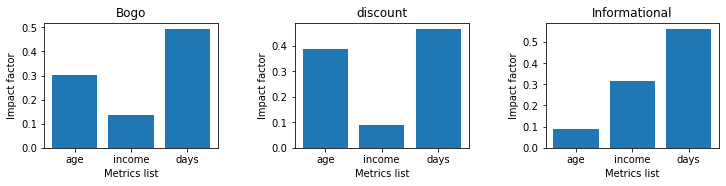

In [21]:
# Identify the most impacting metrics among Age, Income and Days

plt.figure(figsize= [10,2.5])

plt.subplot(1,3,1)
Impact_factor = tree_bogo.feature_importances_[:3]
Metrics = X_train_bogo.columns.values[:3]
plt.bar(Metrics,Impact_factor)
plt.xlabel('Metrics list')
plt.ylabel('Impact factor')
plt.title('Bogo')

plt.subplot(1,3,2)
Impact_factor = tree_discount.feature_importances_[:3]
Metrics = X_train_bogo.columns.values[:3]
plt.bar(Metrics,Impact_factor)
plt.xlabel('Metrics list')
plt.ylabel('Impact factor')
plt.title('discount')

plt.subplot(1,3,3)
Impact_factor = tree_informational.feature_importances_[:3]
Metrics = X_train_bogo.columns.values[:3]
plt.bar(Metrics,Impact_factor)
plt.xlabel('Metrics list')
plt.ylabel('Impact factor')
plt.tight_layout(pad=0.4, w_pad=4.0, h_pad=3.0)
plt.title('Informational')

From the Confusion matrixes for the bogo, discount and informational offers, we can clearly see that the Decision Tree Classifier has relatively good estimation on whether the customers would be affected by affected by Bogo and Discount. However, it is very clear that since most customers would not be affected by the informational offer, the model would prefer to believing that people will not be affected by this type of offer. 

### 3.2 Cross Validation 

we will do cross validation on the testing data, the data will be cut into 5 part 

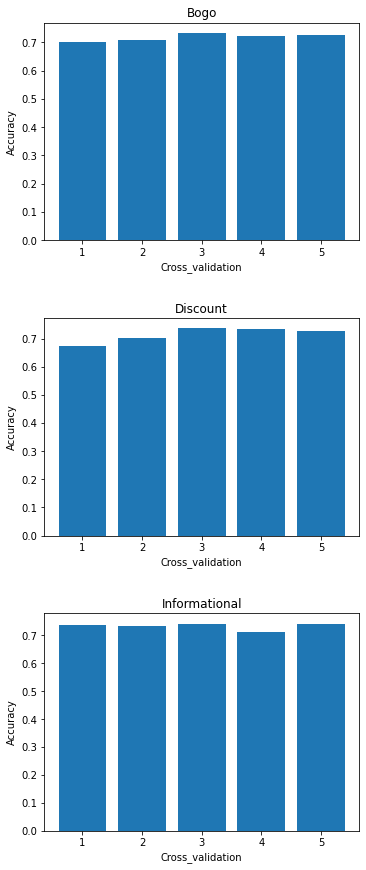

In [37]:
#using Cross Validation to test the robustness of the model solution
plt.figure(figsize= [5,12])

plt.subplot(3,1,1)
scores = cross_validate(tree_bogo, X_test_bogo, y_test_bogo,cv=5, return_train_score=False)
x_cross = [1,2,3,4,5]
plt.bar(x_cross, scores['test_score'])
plt.xlabel('Cross_validation')
plt.ylabel('Accuracy')
plt.title('Bogo')


plt.subplot(3,1,2)
scores = cross_validate(tree_discount, X_test_discount, y_test_discount,cv=5, return_train_score=False)
x_cross = [1,2,3,4,5]
plt.bar(x_cross, scores['test_score'])
plt.xlabel('Cross_validation')
plt.ylabel('Accuracy')
plt.title('Discount')

plt.subplot(3,1,3)
scores = cross_validate(tree_informational, X_test_informational, y_test_informational,cv=5, return_train_score=False)
x_cross = [1,2,3,4,5]
plt.bar(x_cross, scores['test_score'])
plt.xlabel('Cross_validation')
plt.ylabel('Accuracy')
plt.title('Informational')

plt.tight_layout(pad=0.4, w_pad=4.0, h_pad=3.0)

It can be noted that the robustness of our model is very high.

### 3.3 Model Improvement 

We will use GridSearchCV to see if we can slightly improve the prediction accuracy of the Decision Tree classifier

In [64]:
#getting the Decision Tree classifier
tree_bogo.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 16,
 'splitter': 'best'}

In [71]:
#GridsearchCV_Decision tree for bogo 
parameters = {
    'criterion' : ['gini','entropy'],
    'splitter' : ['best','random'],
    'max_depth': [5,10,15,20],
    'min_samples_leaf':[6,8,10,12],
    'min_samples_split':[10,20,30]
}
grid_bogo = GridSearchCV(tree_bogo, param_grid = parameters, cv = 6)
grid_bogo.fit(X_train_bogo,y_train_bogo)
print("The best parameters for bogo offer prediction are: ", grid_bogo.best_params_)
print("The best score is: ",grid_bogo.best_score_ )
best_model=grid_bogo.best_estimator_
y_pred_bogo = best_model.predict(X_test_bogo)
print('Bogo accuracy score is: ', accuracy_score(y_test_bogo, y_pred_bogo))

The best parameters for bogo offer prediction are:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'splitter': 'best'}
The best score is:  0.7333714503525823
Bogo accuracy score is:  0.7269897732325478


In [75]:
#GridsearchCV_Decision tree for discount offer 
parameters = {
    'criterion' : ['gini','entropy'],
    'splitter' : ['best','random'],
    'max_depth': [5,10,15,20],
    'min_samples_leaf':[6,8,10,12],
    'min_samples_split':[10,20,30]
}
grid_discount = GridSearchCV(tree_discount, param_grid = parameters, cv = 6)
grid_discount.fit(X_train_discount,y_train_discount)
print("The best parameters for discount offer prediction are: ", grid_discount.best_params_)
print("The best score is: ",grid_discount.best_score_ )
best_model=grid_discount.best_estimator_
y_pred_discount = best_model.predict(X_test_discount)
print('Discount accuracy score is: ', accuracy_score(y_test_discount, y_pred_discount))

The best parameters for discount offer prediction are:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'splitter': 'best'}
The best score is:  0.720101134112685
Discount accuracy score is:  0.7163247100802854


In [76]:
#GridsearchCV_Decision tree for informational offer 
parameters = {
    'criterion' : ['gini','entropy'],
    'splitter' : ['best','random'],
    'max_depth': [5,10,15,20],
    'min_samples_leaf':[6,8,10,12],
    'min_samples_split':[10,20,30]
}
grid_informational = GridSearchCV(tree_informational, param_grid = parameters, cv = 6)
grid_informational.fit(X_train_informational,y_train_informational)
print("The best parameters for imformational offer prediction are: ", grid_informational.best_params_)
print("The best score is: ",grid_informational.best_score_ )
best_model=grid_informational.best_estimator_
y_pred_informational = best_model.predict(X_test_informational)
print('Informational offer accuracy score is: ', accuracy_score(y_test_informational, y_pred_informational))

The best parameters for imformational offer prediction are:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'best'}
The best score is:  0.7487130123129013
Informational offer accuracy score is:  0.7399684044233807


It can be concluded that the improvment is relatively small. 

## 3.3 Justification  

In this data analysis project, the most important question we are concerned is Which demographic groups respond best to which offer type? What is the best offer strategy for Starbucks?

According to our machine learning-based model analysis and data visualization based investigation, we know that Bogo offer is always with the largest expense and the informational offer is always with the lowest expense. Therefore, our final strategy is here.

(1). Achieve the customer's information of age, income level, gender. etc..

(2). Check if the customer would be affected by the informational offer with our tree_informational model. We will provide more informational offers to the customer when the system shows that the informational offer is impacting. If the customer would be affected by the informational offer, then we won't push the other two types of offers to him or her.

(3). If the customer won't be impacted by the informational offer, then check if the customer would be affected by the discount offer with our tree_discount model, if the customer would be affected by the discount offer, then we won't push the Bogo offer to the customer.

(4). If the customer will not be affected by the informational offer or discount offer, check if the customer would be affected by the Bogo offer, if the customer would be affected by the discount offer, then we would increase the bogo offer push for this customer, otherwise, we can assume that this customer won't be affected by any kind of reward offer, then we do not need to push any offer to him or her.

# 4. Conclusion 

In this project, l combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I build several machine learning models to analysis if the customers will be affected by the reward offers or not, I assess the accuracy to describe the performance of each my models. 

Decision Tree Classifier gave me the best accuracy of prediction
Bogo offer prediction accuracy:  0.7269897732325478
Discount offer prediction accuracy:  0.7163247100802854
Informational offer prediction accuracy:  0.7399684044233807

After that, I use cross-validation and confusion matrix to further validate the robustness of my model and found that my model is robust.

## 4.1 Reflection and future work

In this data analysis, I did not consider some other parameters like the "difficulty" of the offer and the rewards level of each individual offer, I think this is the most important reason that our prediction accuracy is limited by ~70–75%. In the near future, I will include more metrics in this data analysis.